## Macro Trade

### EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader as pdr

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pykalman import KalmanFilter

result_df = pd.read_csv("/Users/arielazria/Library/CloudStorage/OneDrive-TheUniversityofChicago/School/Financial Analytics/Final Project/result_df_regular.csv")

In [2]:
import sys
sys.path.append('/Users/arielazria/Library/CloudStorage/OneDrive-TheUniversityofChicago/School/Financial Analytics/Final Project')

import importlib
from functions_logic_changed import *

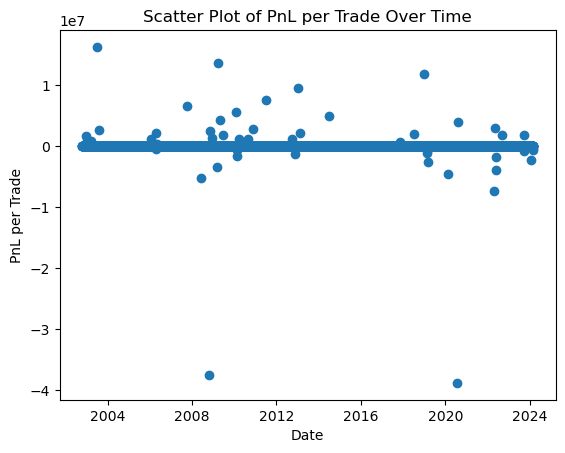

In [3]:
result_df['date'] = pd.to_datetime(result_df['date'])
plt.scatter(result_df.set_index('date').index, result_df['PnL_per_trade'])
plt.xlabel('Date')
plt.ylabel('PnL per Trade')
plt.title('Scatter Plot of PnL per Trade Over Time')
plt.show()

This trade would be much better to run where there aren't huge macro events affecting the market. 2020 and 2008/2009 were both times when the market crashed.
Thus, a macro factor we would consider is the day-over-day drop in EWJ and FEZ. If the day over day drop is too large, then we shouldn't run the trade
The logic: when there is too large of a day over day drop, there are likely factors at play in the market that impact the trade in unforeseen ways
In addition, in those periods of extreme market turbulence, there are likely other trades to be made that are better bets; thus, the opportunity cost of running this trade would be too high to make it worth running  

Let's look at the drawdowns over time to see if there are instances where we shouldn't trade. 

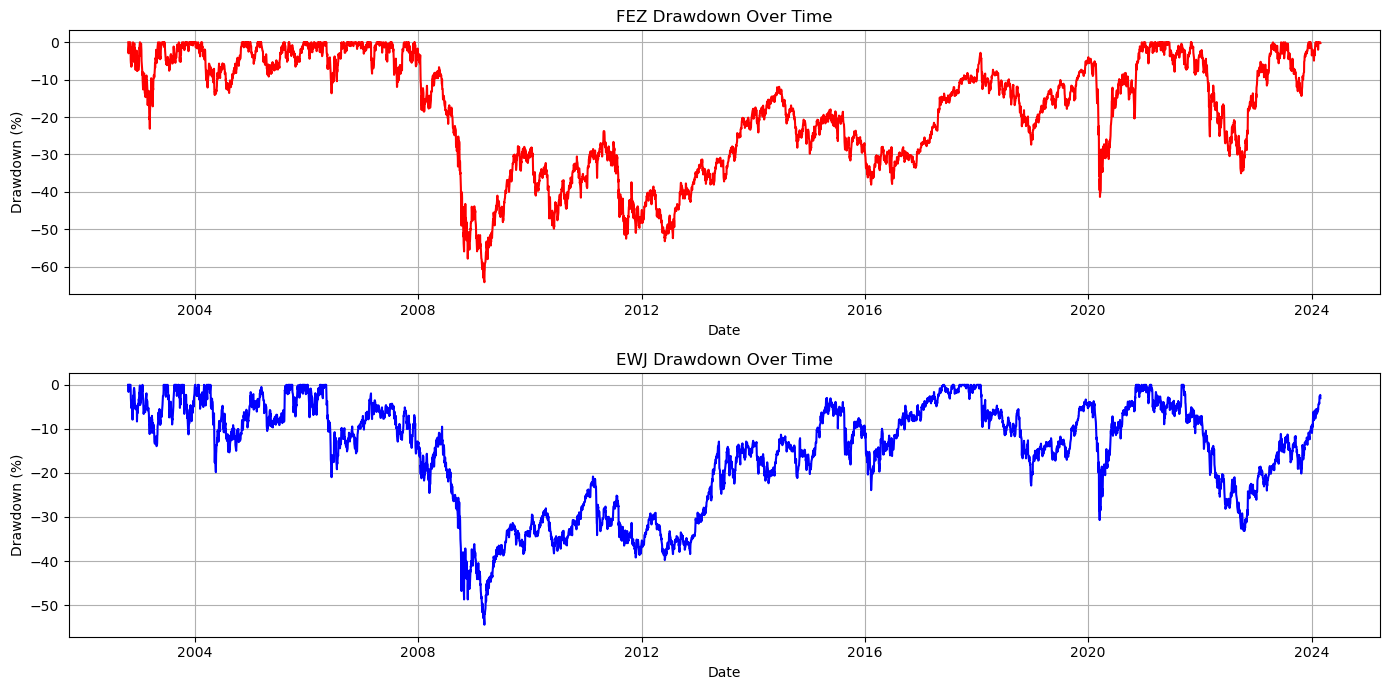

In [4]:
# Ensure the date column is of datetime type and set it as the index
result_df['date'] = pd.to_datetime(result_df['date'])
result_df.set_index('date', inplace=True)

# Calculate drawdowns for both ETFs
result_df['FEZ_drawdown'] = calculate_drawdown(result_df['FEZ Price'])
result_df['EWJ_drawdown'] = calculate_drawdown(result_df['EWJ Price'])

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size for better readability

# FEZ Drawdown
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(result_df.index, result_df['FEZ_drawdown'], label='FEZ Drawdown', color='red')
plt.title('FEZ Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)

# EWJ Drawdown
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(result_df.index, result_df['EWJ_drawdown'], label='EWJ Drawdown', color='blue')
plt.title('EWJ Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [5]:
result_df['EWJ_drawdown'].describe().T

count    5374.000000
mean      -15.405020
std        11.774153
min       -54.452807
25%       -22.573809
50%       -12.897229
75%        -5.922362
max         0.000000
Name: EWJ_drawdown, dtype: float64

In [6]:
result_df['FEZ_drawdown'].describe().T

count    5374.000000
mean      -18.525041
std        15.045151
min       -64.208612
25%       -30.273062
50%       -15.331104
75%        -5.063793
max         0.000000
Name: FEZ_drawdown, dtype: float64

In [7]:
# It looks like a good place to pull the plug on these trade is at -20%. 

# Let's amend our previous functions a bit and reapply the trading logic. This time, we'll only trade if the max drawdown during the MIN_CONSECUTIVE_DAYS falls above a certain threshold. 

result_df.columns

Index(['Unnamed: 0', 'FEZ Price', 'EWJ Price', 'Z-Score', 'long_size',
       'long_etf', 'trade_condition', 'condition_cumsum', 'condition_count',
       'execute_trade', 'hedge_ratio', 'FEZ_return', 'EWJ_return',
       'PnL_per_trade', 'daily_PnL_per_trade', 'long_shares', 'short_shares',
       'long_allocation', 'short_allocation', 'capital_layover',
       'prev_hedge_ratio', 'EWJ_min', 'FEZ_min', 'FEZ_drawdown',
       'EWJ_drawdown'],
      dtype='object')

In [8]:
cols_to_keep = ['FEZ Price', 'EWJ Price', 'Z-Score', 'FEZ_drawdown', 'EWJ_drawdown']
macro_df = result_df[cols_to_keep]

In [9]:
macro_df

,FEZ Price,EWJ Price,Z-Score,FEZ_drawdown,EWJ_drawdown
date,,,,,
2002-10-22,12.568131,20.394314,-1.084152,0.000000,0.000000
2002-10-23,12.250083,20.727160,-0.957287,-2.530595,0.000000
2002-10-24,12.198788,20.394314,-1.012163,-2.938732,-1.605843
2002-10-25,12.337286,20.848198,-0.950692,-1.836752,0.000000
2002-10-28,12.527097,20.848198,-0.987688,-0.326498,0.000000
...,...,...,...,...,...
2024-02-22,50.344189,68.900002,1.007151,0.000000,-2.689155
2024-02-23,50.374134,69.010002,1.022755,0.000000,-2.533795
2024-02-26,50.434017,69.000000,1.009133,0.000000,-2.547922


In [10]:
macro_trial = macro_df.copy()
UPPERBOUND = 1
LOWERBOUND = -1
LONG = -50000000
MIN_CONSECUTIVE_DAYS = 3 
DRAWDOWN_THRESH = 0.5

In [11]:
macro_trial

,FEZ Price,EWJ Price,Z-Score,FEZ_drawdown,EWJ_drawdown
date,,,,,
2002-10-22,12.568131,20.394314,-1.084152,0.000000,0.000000
2002-10-23,12.250083,20.727160,-0.957287,-2.530595,0.000000
2002-10-24,12.198788,20.394314,-1.012163,-2.938732,-1.605843
2002-10-25,12.337286,20.848198,-0.950692,-1.836752,0.000000
2002-10-28,12.527097,20.848198,-0.987688,-0.326498,0.000000
...,...,...,...,...,...
2024-02-22,50.344189,68.900002,1.007151,0.000000,-2.689155
2024-02-23,50.374134,69.010002,1.022755,0.000000,-2.533795
2024-02-26,50.434017,69.000000,1.009133,0.000000,-2.547922


In [12]:
macro_trial = macro_trading_periods(macro_trial, UPPERBOUND, LOWERBOUND, MIN_CONSECUTIVE_DAYS, DRAWDOWN_THRESH)

In [13]:
macro_trial

,date,FEZ Price,EWJ Price,Z-Score,FEZ_drawdown,EWJ_drawdown,trade_condition,condition_cumsum,condition_count,execute_trade,entry_zscore,in_trade
0,2002-10-22,12.568131,20.394314,-1.084152,0.000000,0.000000,True,1,1,False,NaN,False
1,2002-10-23,12.250083,20.727160,-0.957287,-2.530595,0.000000,False,2,0,False,NaN,False
2,2002-10-24,12.198788,20.394314,-1.012163,-2.938732,-1.605843,True,3,1,False,NaN,False
3,2002-10-25,12.337286,20.848198,-0.950692,-1.836752,0.000000,False,4,0,False,NaN,False
4,2002-10-28,12.527097,20.848198,-0.987688,-0.326498,0.000000,False,4,0,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5369,2024-02-22,50.344189,68.900002,1.007151,0.000000,-2.689155,True,181,1,False,NaN,False
5370,2024-02-23,50.374134,69.010002,1.022755,0.000000,-2.533795,True,181,2,False,NaN,False
5371,2024-02-26,50.434017,69.000000,1.009133,0.000000,-2.547922,True,181,3,True,1.009133,True
5372,2024-02-27,50.673565,69.180000,0.997527,0.000000,-2.293699,False,182,0,False,1.009133,False


In [14]:
macro_trial = process_trading_periods(macro_trial)

In [15]:
macro_trial

,date,FEZ Price,EWJ Price,Z-Score,FEZ_drawdown,EWJ_drawdown,trade_condition,condition_cumsum,condition_count,execute_trade,entry_zscore,in_trade,hedge_ratio
0,2002-10-22,12.568131,20.394314,-1.084152,0.000000,0.000000,True,1,1,False,NaN,False,NaN
1,2002-10-23,12.250083,20.727160,-0.957287,-2.530595,0.000000,False,2,0,False,NaN,False,NaN
2,2002-10-24,12.198788,20.394314,-1.012163,-2.938732,-1.605843,True,3,1,False,NaN,False,NaN
3,2002-10-25,12.337286,20.848198,-0.950692,-1.836752,0.000000,False,4,0,False,NaN,False,NaN
4,2002-10-28,12.527097,20.848198,-0.987688,-0.326498,0.000000,False,4,0,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,2024-02-22,50.344189,68.900002,1.007151,0.000000,-2.689155,True,181,1,False,NaN,False,0.718393
5370,2024-02-23,50.374134,69.010002,1.022755,0.000000,-2.533795,True,181,2,False,NaN,False,0.718727
5371,2024-02-26,50.434017,69.000000,1.009133,0.000000,-2.547922,True,181,3,True,1.009133,True,0.719177
5372,2024-02-27,50.673565,69.180000,0.997527,0.000000,-2.293699,False,182,0,False,1.009133,False,NaN


In [16]:
# Long versus short
macro_trial['long_etf'] = np.where(
    (macro_trial['Z-Score'] > UPPERBOUND) & (macro_trial['Z-Score'] > 0), 'FEZ',
    np.where(
        (macro_trial['Z-Score'] < LOWERBOUND) & (macro_trial['Z-Score'] < 0), 'EWJ',
        np.nan
    )
)

In [17]:
macro_trial

,date,FEZ Price,EWJ Price,Z-Score,FEZ_drawdown,EWJ_drawdown,trade_condition,condition_cumsum,condition_count,execute_trade,entry_zscore,in_trade,hedge_ratio,long_etf
0,2002-10-22,12.568131,20.394314,-1.084152,0.000000,0.000000,True,1,1,False,NaN,False,NaN,EWJ
1,2002-10-23,12.250083,20.727160,-0.957287,-2.530595,0.000000,False,2,0,False,NaN,False,NaN,nan
2,2002-10-24,12.198788,20.394314,-1.012163,-2.938732,-1.605843,True,3,1,False,NaN,False,NaN,EWJ
3,2002-10-25,12.337286,20.848198,-0.950692,-1.836752,0.000000,False,4,0,False,NaN,False,NaN,nan
4,2002-10-28,12.527097,20.848198,-0.987688,-0.326498,0.000000,False,4,0,False,NaN,False,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,2024-02-22,50.344189,68.900002,1.007151,0.000000,-2.689155,True,181,1,False,NaN,False,0.718393,FEZ
5370,2024-02-23,50.374134,69.010002,1.022755,0.000000,-2.533795,True,181,2,False,NaN,False,0.718727,FEZ
5371,2024-02-26,50.434017,69.000000,1.009133,0.000000,-2.547922,True,181,3,True,1.009133,True,0.719177,FEZ
5372,2024-02-27,50.673565,69.180000,0.997527,0.000000,-2.293699,False,182,0,False,1.009133,False,NaN,nan


In [18]:
macro_trial = calculate_trade_pnl(macro_trial, LONG)

In [19]:
macro_trial.columns

Index(['date', 'FEZ Price', 'EWJ Price', 'Z-Score', 'FEZ_drawdown',
       'EWJ_drawdown', 'trade_condition', 'condition_cumsum',
       'condition_count', 'execute_trade', 'entry_zscore', 'in_trade',
       'hedge_ratio', 'long_etf', 'FEZ_return', 'EWJ_return', 'PnL_per_trade',
       'daily_PnL_per_trade', 'long_shares', 'short_shares', 'long_allocation',
       'short_allocation', 'capital_layover', 'return', 'prev_hedge_ratio'],
      dtype='object')

In [20]:
macro_result = create_trade_summary_df(macro_trial)

In [27]:
macro_result.to_csv('macro_results')

In [30]:
macro_result

,date,long_etf,hedge_ratio,long_allocation,short_allocation,capital_layover,entry_zscore,PnL_per_trade,daily_PnL_per_trade,return
0,2002-11-26,EWJ,0.579447,5.155867e+07,-2.987552e+07,2.168315e+07,-1.031173,1.534662e+06,1.705180e+05,0.070777
1,2002-12-03,EWJ,0.602062,5.329034e+07,-3.180987e+07,2.148047e+07,-1.065807,-1.247268e+06,-1.247268e+06,-0.058065
2,2002-12-09,EWJ,0.600288,5.538349e+07,-3.335115e+07,2.203235e+07,-1.107670,-2.022921e+06,-2.022921e+06,-0.091816
3,2002-12-13,EWJ,0.591130,5.391342e+07,-3.204049e+07,2.187293e+07,-1.078268,-6.979176e+05,-6.979176e+05,-0.031908
4,2002-12-19,EWJ,0.607825,6.024085e+07,-3.614768e+07,2.409317e+07,-1.204817,2.446156e+05,2.446156e+05,0.010153
...,...,...,...,...,...,...,...,...,...,...
153,2023-09-28,FEZ,0.678751,-5.042076e+07,3.442084e+07,-1.599992e+07,1.008415,-7.249049e+05,-3.624525e+05,0.045307
154,2024-01-17,FEZ,0.687066,-6.382321e+07,4.560317e+07,-1.822004e+07,1.276464,9.686816e+05,9.686816e+05,-0.053166
155,2024-01-23,FEZ,0.686782,-6.626861e+07,4.588578e+07,-2.038283e+07,1.325372,5.340514e+05,5.340514e+05,-0.026201
156,2024-02-21,FEZ,0.714107,-5.091784e+07,3.633664e+07,-1.458120e+07,1.018357,-6.299826e+05,-2.099942e+05,0.043205


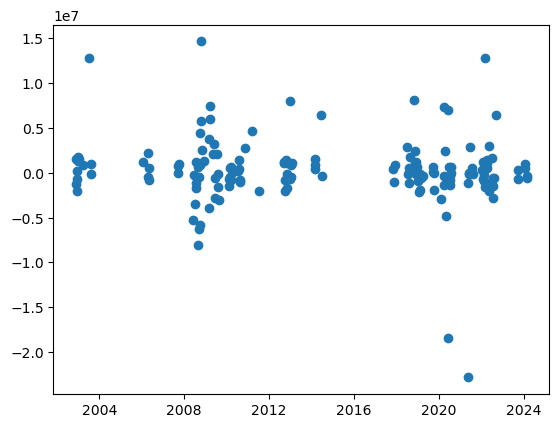

In [31]:
plt.scatter(macro_result['date'], macro_result['PnL_per_trade'])